In [1]:
# Taken from https://github.com/xiongyihui/tdoa/blob/master/gcc_phat.py

"""
 Estimate time delay using GCC-PHAT 
 Copyright (c) 2017 Yihui Xiong
 Licensed under the Apache License, Version 2.0 (the "License");
 you may not use this file except in compliance with the License.
 You may obtain a copy of the License at
     http://www.apache.org/licenses/LICENSE-2.0
 Unless required by applicable law or agreed to in writing, software
 distributed under the License is distributed on an "AS IS" BASIS,
 WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 See the License for the specific language governing permissions and
 limitations under the License.
"""

import numpy as np


def gcc_phat(sig, refsig, fs=1, max_tau=None, interp=16):
    '''
    This function computes the offset between the signal sig and the reference signal refsig
    using the Generalized Cross Correlation - Phase Transform (GCC-PHAT)method.
    '''
    
    # make sure the length for the FFT is larger or equal than len(sig) + len(refsig)
    n = sig.shape[0] + refsig.shape[0]

    # Generalized Cross Correlation Phase Transform
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)

    cc = np.fft.irfft(R / np.abs(R), n=(interp * n))

    max_shift = int(interp * n / 2)
    if max_tau:
        max_shift = np.minimum(int(interp * fs * max_tau), max_shift)

    cc = np.concatenate((cc[-max_shift:], cc[:max_shift+1]))

    # find max cross correlation index
    shift = np.argmax(np.abs(cc)) - max_shift

    tau = shift / float(interp * fs)
    
    return tau, cc


def main():
    
    refsig = np.linspace(1, 10, 10)

    for i in range(0, 10):
        sig = np.concatenate((np.linspace(0, 0, i), refsig, np.linspace(0, 0, 10 - i)))
        offset, _ = gcc_phat(sig, refsig)
        print(offset)


if __name__ == "__main__":
    main()


0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [2]:
Fs = 8000
dt = 1/Fs #0.125e-3
f1 = 100
tdelay = 0.625e-03 # try different values
t3 = np.linspace(0.0,1.0,Fs)
x3 = np.cos(2*np.pi*f1*t3);
x4 = np.cos(2*np.pi*f1*(t3-tdelay));
gcc_phat(x4,x3)


(0.375,
 array([-0.02514735, -0.02196879, -0.01847165, ..., -0.0303065 ,
        -0.02794452, -0.02514735]))

[-3, -2, -3, -2]
GCC-PHAT: -2.0
XCORR: -4


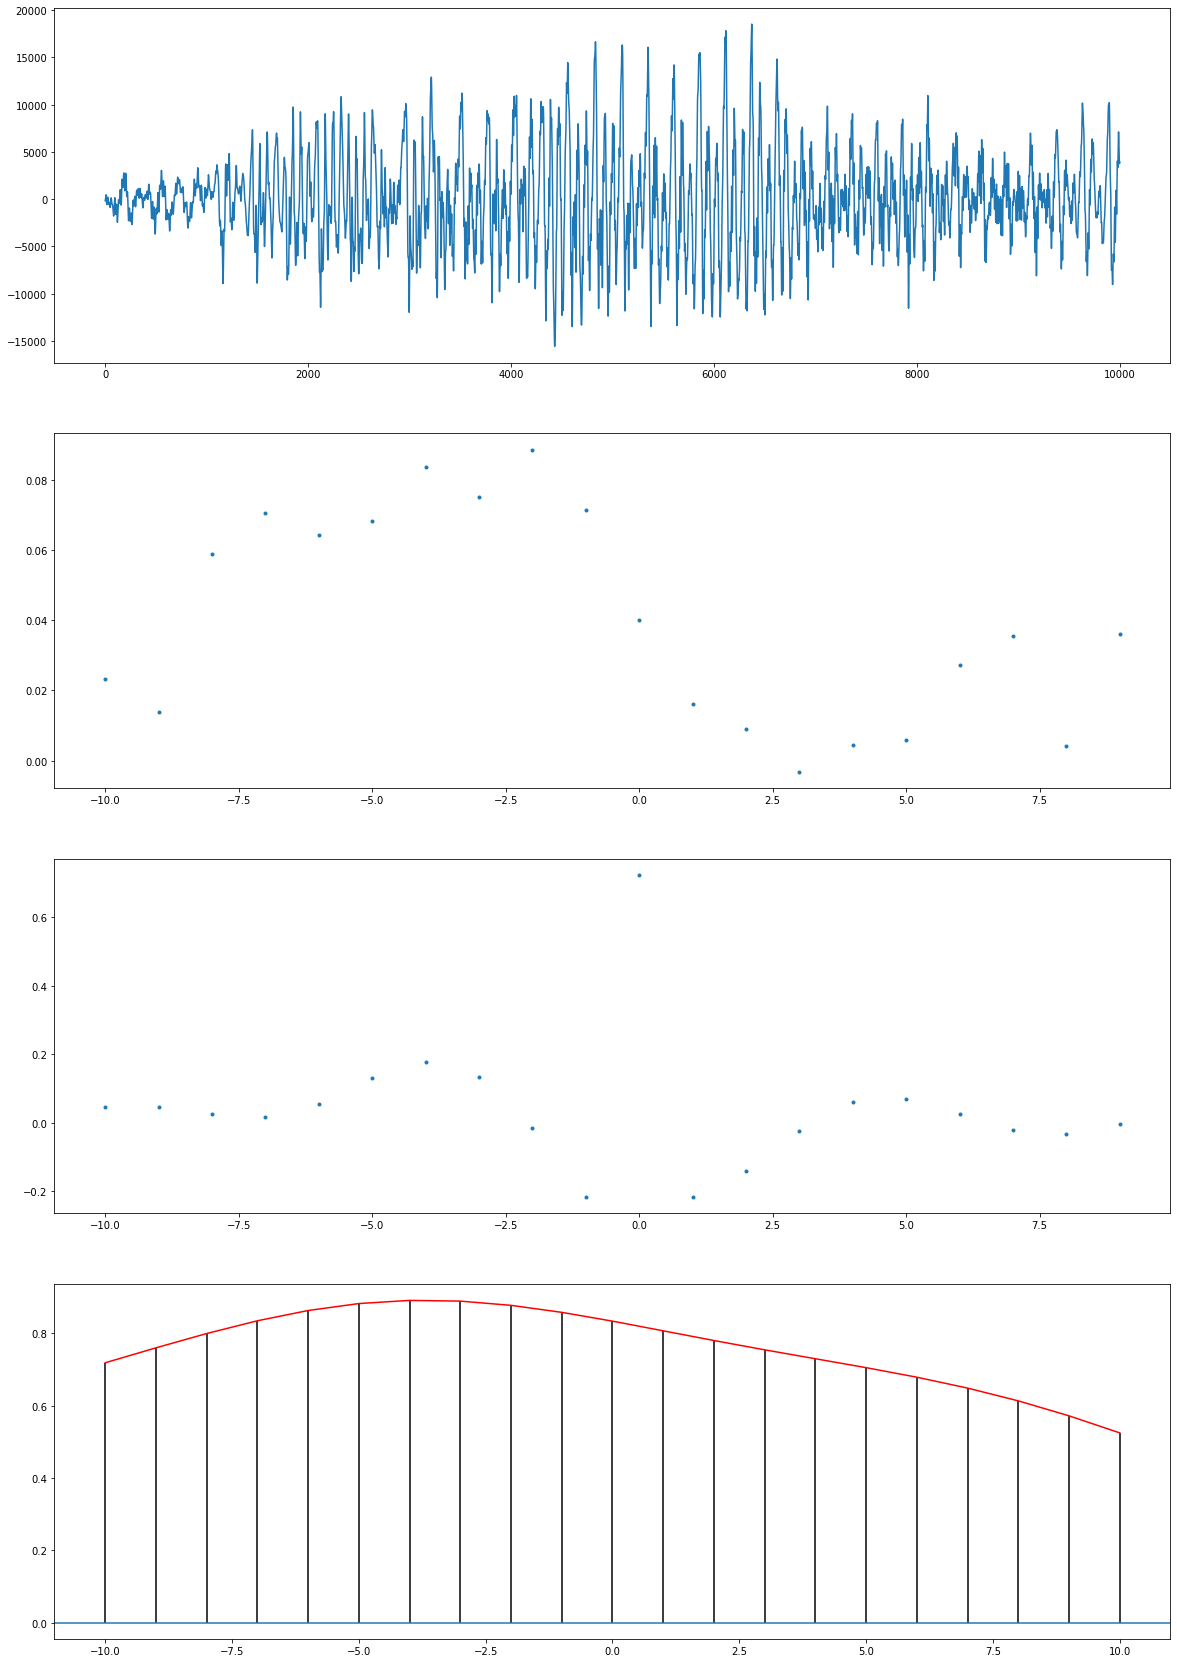

In [3]:
import numpy as np
import statistics
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
from scipy.signal import kaiserord, lfilter, firwin, freqz


samplerate, data = wavfile.read("Q69905.wav",'rb')
samples = np.arange(20000,30000)

fir_filter = firwin(123,0.75)
channel_1 = lfilter(fir_filter,1, data[samples,0])
channel_2 = lfilter(fir_filter,1, data[samples,1])
channel_3 = lfilter(fir_filter,1, data[samples,2])
channel_4 = lfilter(fir_filter,1, data[samples,3])

noise_1 = np.random.normal(0,1000,len(channel_1))
noise_2 = np.random.normal(0,1000,len(channel_2))
noise_3 = np.random.normal(0,1000,len(channel_3))
noise_4 = np.random.normal(0,1000,len(channel_4))

print([statistics.mean(data[:,0]),  statistics.mean(data[:,1]), statistics.mean(data[:,2]), statistics.mean(data[:,3])])

# delay, gcc = gcc_phat(data[samples,0].astype(float)+10, data[samples,2].astype(float)+12, interp=1)
delay, gcc = gcc_phat(channel_1 + noise_1, channel_3 + noise_3, interp=1)
delay_no_noise, gcc_no_noise = gcc_phat(channel_1 , channel_3 , interp=1)

plt.figure(figsize=(20,30))
plt.subplot(4, 1, 1)
plt.plot(data[samples,0])
plt.subplot(4, 1, 2)
plt.plot(np.arange(-10,10),gcc[9990:10010],'.') # [9950:10050]
plt.subplot(4, 1, 3)
plt.plot(np.arange(-10,10),gcc_no_noise[9990:10010],'.') # [9950:10050]
plt.subplot(4, 1, 4)
lags,c, line, b = plt.xcorr(channel_1,channel_3)
plt.plot(lags,c,color='r')

print('GCC-PHAT: ' + str(delay))
print('XCORR: ' +  str(lags[np.argmax(c)]))
Audio(channel_1 + noise_1, rate=44100)